# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [60]:
# Nothing To Dos

### Imports


In [61]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [62]:
files = os.listdir(os.curdir + "/second_try")
parquet_files = []
for file in files:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
print(len(parquet_files))

668


In [68]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    print(file)
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    if parts[1] == "dataset":
        dataset = parts[0]
        method = parts[2]
        fold = parts[-1]
    elif parts[2] == "dataset":
        dataset = parts[0] + parts[1]
        method = parts[3]
        fold = parts[-1]
    elif parts[3] == "dataset":
        dataset = parts[0] + parts[1] + parts[2]
        method = parts[4]
        fold = parts[-1]
    if method == "xxx":
        print("xxx is not a valid method name")
    else:
        df = pd.read_parquet("second_try/" + file)
        df = df[df['status'] == 'success']
        try:
            metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
            value = np.average(metric_accuracy)
            print({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value})
            df_all = df_all.append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
        except KeyError as e:
            print(str(e) + " for file " + str(file))
print(df_all)

results_wilt_dataset_bioautoml_lgbm_classifier_pipeline_2.parquet
{'Dataset': 'wilt', 'Method': 'bioautoml', 'Fold': '2', 'Value': 0.9861780564044429}
results_car_dataset_bioautoml_lgbm_classifier_pipeline_6.parquet
{'Dataset': 'car', 'Method': 'bioautoml', 'Fold': '6', 'Value': 0.7723432619126505}
results_wine_quality_white_dataset_autogluon_lgbm_classifier_pipeline_4.parquet
{'Dataset': 'winequalitywhite', 'Method': 'autogluon', 'Fold': '4', 'Value': 0.9421850583519673}
results_kr_vs_kp_dataset_autofeat_lgbm_classifier_pipeline_9.parquet
{'Dataset': 'krvskp', 'Method': 'autofeat', 'Fold': '9', 'Value': 0.9389213352871487}
results_abalone_dataset_correlationBasedFS_lgbm_classifier_pipeline_0.parquet
{'Dataset': 'abalone', 'Method': 'correlationBasedFS', 'Fold': '0', 'Value': 0.9844739942717449}
results_pc4_dataset_bioautoml_lgbm_classifier_pipeline_7.parquet
{'Dataset': 'pc4', 'Method': 'bioautoml', 'Fold': '7', 'Value': 0.8970125554562962}
results_pc4_dataset_mljar_lgbm_classifier_pi

In [69]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

             Dataset              Method     Value
0            abalone            autofeat  0.819402
1            abalone  correlationBasedFS  0.871825
2            abalone               mljar  0.906537
3            abalone            original  0.922055
4         australian            autofeat  0.854300
..               ...                 ...       ...
74  winequalitywhite            autofeat  0.848570
75  winequalitywhite           autogluon  0.862041
76  winequalitywhite           bioautoml  0.814809
77  winequalitywhite  correlationBasedFS  0.898586
78  winequalitywhite            original  0.793592

[79 rows x 3 columns]


In [70]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

             Dataset              Method     Value    StdDev  \
0            abalone            autofeat  0.819402  0.101732   
1            abalone  correlationBasedFS  0.871825  0.064189   
2            abalone               mljar  0.906537  0.027967   
3            abalone            original  0.922055  0.029714   
4         australian            autofeat  0.854300  0.089712   
..               ...                 ...       ...       ...   
74  winequalitywhite            autofeat  0.848570  0.178188   
75  winequalitywhite           autogluon  0.862041  0.086511   
76  winequalitywhite           bioautoml  0.814809  0.119195   
77  winequalitywhite  correlationBasedFS  0.898586  0.136011   
78  winequalitywhite            original  0.793592  0.098753   

                            Value_with_StdDev  
0     0.8194015784898294 ± 0.1017316426295408  
1    0.8718249558849116 ± 0.06418907916916664  
2   0.9065366690453756 ± 0.027967032734993926  
3    0.9220546053046594 ± 0.02971391233

In [71]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('0 ± 0')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+----+------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
|    |        Dataset         |                 autofeat                  |                 autogluon                 |                 bioautoml                 |            correlationBasedFS             |                   mljar                   |                 original                  |
+----+------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
| 0  |        abalone         |  0.8194015784898294 ± 0.1017316426295408  |                   0 ± 0             

### Boxplots

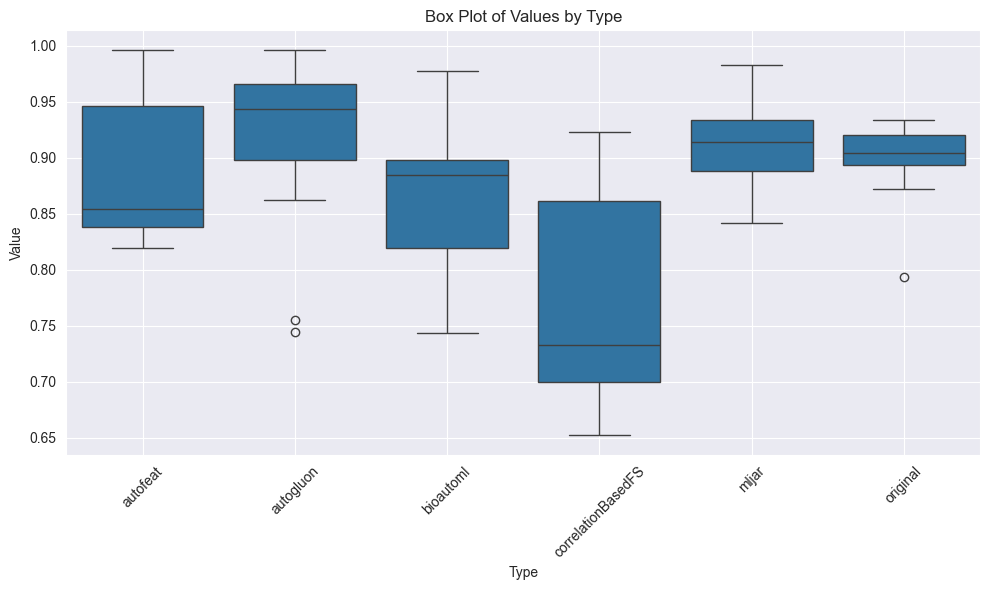

In [72]:
# Extract values
def extract_value(value_with_stddev):
    value, _ = value_with_stddev.split(' ± ')
    if float(value) == float(0):
        return None
    else:
        return float(value)

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()